# Analysis of the productivity and efficiency of a mining truck with Python

The objective of this notebook is to be practical and save time when generating a report, since you only have to enter the data and the calculations are made automatically.

I am going to perform a statistical analysis of the production and efficiency of a mining truck with Python (Pandas Library).

Units = US (Imperial) Units

- 1. Importing libraries 
- 2. Reading the dataset
- 3. Adjusting the data
- 4. General graph of the data
- 5. Production (Payload- Tons)
- 6. Target and maximum Payload
- 7. 10/10/20 Rule
- 8. Fuel consumption analysis
- 9. Load Factor (%) & Fuel Efficiency (tons/gal)
- 10. Operational Effectiveness (Hours)
- 11. Increased haul & return speed = Increased cycles

  <td>
    <a target="_blank" href="https://github.com/RicardoMan/Mechanical_Projects"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>

## 1. Importing libraries 

In [42]:
import warnings
warnings.filterwarnings('ignore')

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

sns.set(style="darkgrid")
%matplotlib inline

mpl.rcParams['figure.figsize'] = (13, 8)
mpl.rcParams['axes.grid'] = False

## 2. Reading the dataset

One year of data for annual analysis

In [43]:
from zipfile import ZipFile
import os

csv_path = "equipment1.csv"

#df = pd.read_csv(csv_path, parse_dates=['Time/Date'], header=0, index_col=['Time/Date'] )
df = pd.read_csv(csv_path)
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal)
0,01/01/2020 20:53:02,22566,SPD00397,186.329,00:09:32,2.1,00:06:27,00:03:09,00:01:08,00:10:50,1.9,00:31:06,4.0,5,30.750
1,01/01/2020 21:24:09,22566,SPD00397,205.072,00:07:21,1.9,00:01:58,00:02:31,00:02:29,00:11:04,1.8,00:25:23,3.7,5,18.000
2,01/01/2020 21:49:32,22567,SPD00397,196.362,00:06:48,1.9,00:00:08,00:03:32,00:02:36,00:11:54,1.9,00:24:58,3.8,6,17.625
3,01/01/2020 22:14:30,22567,SPD00397,210.474,00:07:36,1.9,00:03:46,00:04:02,00:00:57,00:11:24,1.9,00:27:45,3.8,7,18.125
4,01/01/2020 22:42:15,22568,SPD00397,208.159,00:07:03,1.9,00:01:12,00:04:23,00:01:15,00:11:09,1.9,00:25:02,3.8,7,17.750


## 3. Adjusting the data

Extracting day, month and year from column 'Time/Date' and creating new columns 'year', 'month' and 'day'.

In [44]:
df['year'] = pd.DatetimeIndex(df['Time/Date']).year
df['month'] = pd.DatetimeIndex(df['Time/Date']).month
df['day'] = pd.DatetimeIndex(df['Time/Date']).day

import calendar
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df.month = pd.Categorical(df.month, months)
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day
0,01/01/2020 20:53:02,22566,SPD00397,186.329,00:09:32,2.1,00:06:27,00:03:09,00:01:08,00:10:50,1.9,00:31:06,4.0,5,30.750,2020,Jan,1
1,01/01/2020 21:24:09,22566,SPD00397,205.072,00:07:21,1.9,00:01:58,00:02:31,00:02:29,00:11:04,1.8,00:25:23,3.7,5,18.000,2020,Jan,1
2,01/01/2020 21:49:32,22567,SPD00397,196.362,00:06:48,1.9,00:00:08,00:03:32,00:02:36,00:11:54,1.9,00:24:58,3.8,6,17.625,2020,Jan,1
3,01/01/2020 22:14:30,22567,SPD00397,210.474,00:07:36,1.9,00:03:46,00:04:02,00:00:57,00:11:24,1.9,00:27:45,3.8,7,18.125,2020,Jan,1
4,01/01/2020 22:42:15,22568,SPD00397,208.159,00:07:03,1.9,00:01:12,00:04:23,00:01:15,00:11:09,1.9,00:25:02,3.8,7,17.750,2020,Jan,1


Transforming data (hh: mm: ss) to minutes in order to improve the data for the analysis

#### note: I am not going to replace the column names (hh: mm: ss), but keep in mind that they will be minutes

####  hh:mm:ss to minutes :

In [45]:
df['Travel Empty Time (hh:mm:ss)'] = pd.to_timedelta(df['Travel Empty Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Stopped Empty Time (hh:mm:ss)'] = pd.to_timedelta(df['Stopped Empty Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Load Time (hh:mm:ss)'] = pd.to_timedelta(df['Load Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Stopped Loaded Time (hh:mm:ss)'] = pd.to_timedelta(df['Stopped Loaded Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Loaded Travel Time (hh:mm:ss)'] =pd.to_timedelta(df['Loaded Travel Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Cycle Time (hh:mm:ss)'] = pd.to_timedelta(df['Cycle Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day
0,01/01/2020 20:53:02,22566,SPD00397,186.329,9.533,2.1,6.450,3.150,1.133,10.833,1.9,31.100,4.0,5,30.750,2020,Jan,1
1,01/01/2020 21:24:09,22566,SPD00397,205.072,7.350,1.9,1.967,2.517,2.483,11.067,1.8,25.383,3.7,5,18.000,2020,Jan,1
2,01/01/2020 21:49:32,22567,SPD00397,196.362,6.800,1.9,0.133,3.533,2.600,11.900,1.9,24.967,3.8,6,17.625,2020,Jan,1
3,01/01/2020 22:14:30,22567,SPD00397,210.474,7.600,1.9,3.767,4.033,0.950,11.400,1.9,27.750,3.8,7,18.125,2020,Jan,1
4,01/01/2020 22:42:15,22568,SPD00397,208.159,7.050,1.9,1.200,4.383,1.250,11.150,1.9,25.033,3.8,7,17.750,2020,Jan,1


## 4. General data graphs

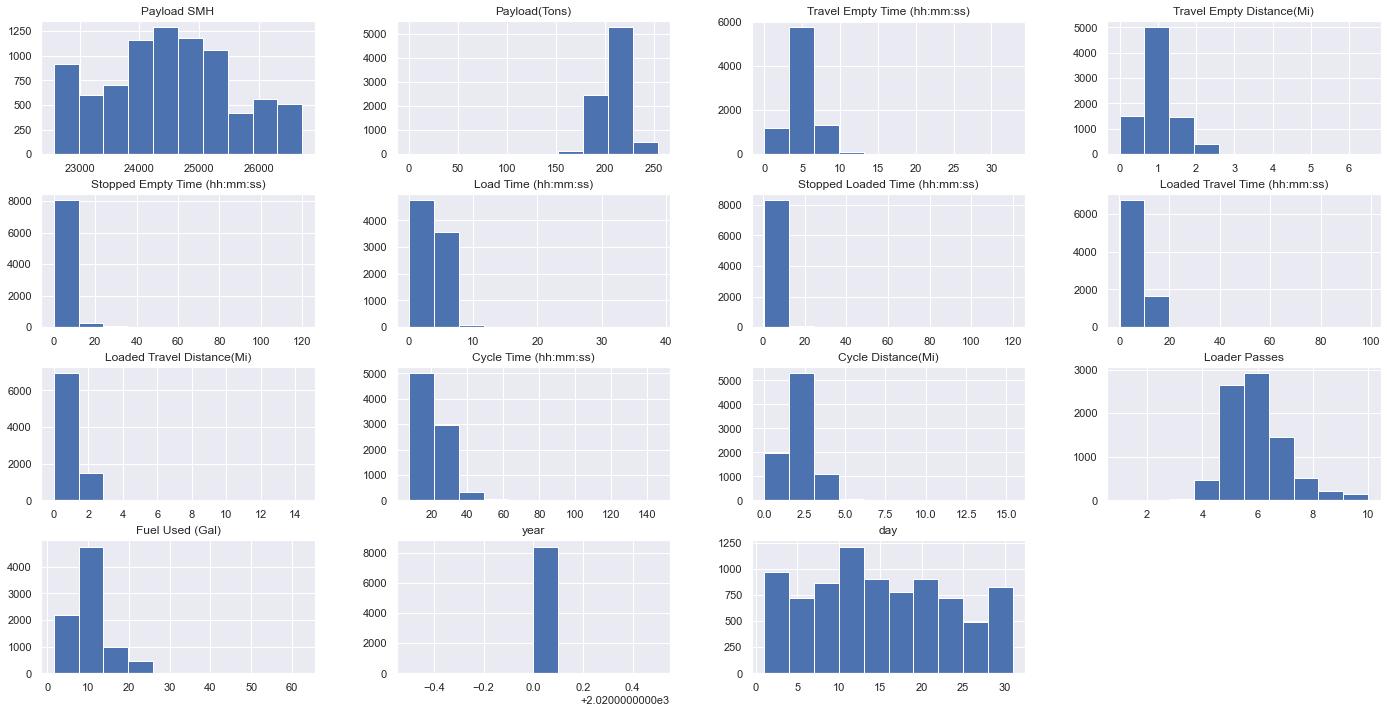

In [46]:
df.hist(figsize=(24,12), log = False);

Here we can visualize the data ranges to specify functions. For example, we can identify the payload, the time and the distance of each cycle of the truck.

## 5. Production (Payload- Tons)

Here are the total tons loaded per month:

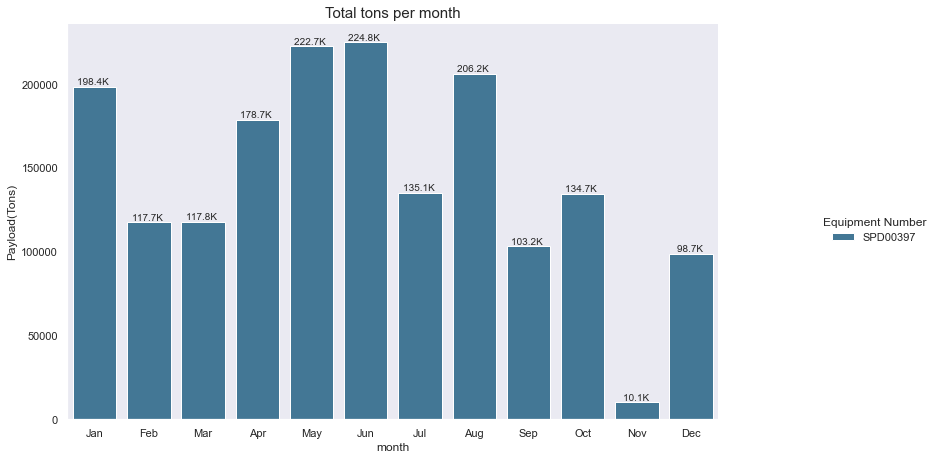

In [47]:
#sns.barplot(x="month", y="Payload(Tons)", data=df, estimator=sum)
g = sns.catplot(x="month", y="Payload(Tons)", data=df, estimator=sum, kind='bar', hue='Equipment Number', legend=True, palette="mako", ci=None)
g.fig.set_size_inches(15, 8)
g.fig.subplots_adjust(top=0.81, right=0.8)

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height() / 1000):.1f}K ' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
    
plt.title('Total tons per month', fontdict = {'fontsize' : 15});

Here you can see which month there was the highest production. In this case, for example, there was apparently some mechanical failure which caused lost production times in the month of November.

#### Total tons per month (values):

In [48]:
df.groupby(['Equipment Number','month'])["Payload(Tons)"].sum()

Equipment Number  month
SPD00397          Jan      198426.790
                  Feb      117677.837
                  Mar      117829.980
                  Apr      178716.861
                  May      222714.664
                  Jun      224796.463
                  Jul      135053.689
                  Aug      206163.498
                  Sep      103198.451
                  Oct      134662.857
                  Nov       10052.152
                  Dec       98663.286
Name: Payload(Tons), dtype: float64

#### Summary of the loads (tons):
Here are some statistics of the production of the Truck.

In [49]:
#using the columns ['Payload (Tons)'] with groupby
df.groupby(['Equipment Number','month'])["Payload(Tons)"].describe()

count     mean     std      min      25%      50%  \
Equipment Number month                                                       
SPD00397         Jan     931.0  213.133  15.153    2.646  205.237  213.782   
                 Feb     556.0  211.651  21.321    8.049  205.926  214.664   
                 Mar     558.0  211.165  17.232   61.411  205.320  212.404   
                 Apr     842.0  212.253  15.168   12.789  204.079  213.561   
                 May    1067.0  208.730  13.463    2.867  201.213  209.372   
                 Jun    1091.0  206.046  16.021    0.110  198.015  207.387   
                 Jul     666.0  202.783  16.031    0.441  193.826  204.355   
                 Aug    1003.0  205.547  12.897    4.410  197.740  206.064   
                 Sep     505.0  204.353  15.945    0.221  197.133  204.851   
                 Oct     669.0  201.290  13.681  146.858  192.503  202.756   
                 Nov      48.0  209.420  11.027  189.967  201.185  209.647   
                 Dec     462.0  213.557  11.354  173.649  206.284  213.341   

                            75%      max  
Equipment Number month                    
SPD00397         Jan    221.775  246.307  
                 Feb    221.610  243.330  
                 Mar    219.956  253.583  
                 Apr    221.610  242.999  
                 May    217.089  247.409  
                 Jun    215.822  244.653  
                 Jul    213.010  233.848  
                 Aug    213.561  241.014  
                 Sep    212.679  244.873  
                 Oct    211.025  239.140  
                 Nov    217.090  232.084  
                 Dec    221.830  240.684

Here you can see which month there were more cycles in the 'Count' column, which is the month where the machine was operated the most.

Another very important thing: the average and distribution of loads. We do not want an overload of the truck or a low utilization of the machine. There is a rule for this called the 10/10/20 Rule.

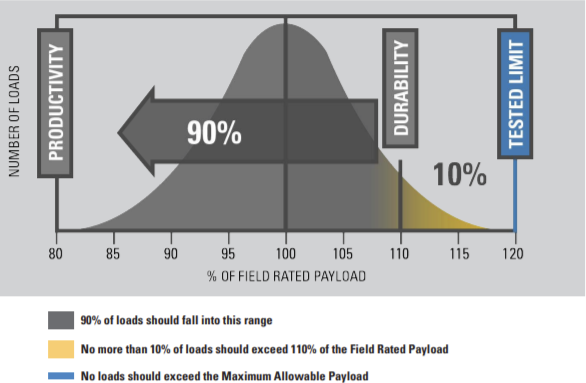


## 6. Target and maximum Payload
The target load for this model is 209 Tons (US)/190 Metric Tons
#### Target:

In [50]:
payload = 209 #put the target here 

#### Defining production ranges according to the 10/10/20 Rule:

In [51]:
# 80% of 209 = 0.8 × 209 = 167.2
min_load = 0.8 * payload
print('minimum ton limit:', min_load, 'Tons')

minimum ton limit: 167.20000000000002 Tons


In [52]:
# 110% of 209 = 1.1 × 209 = 229.9
percent10_load = 1.1 * payload
print('minimum ton limit of the 10%:', percent10_load, 'Tons')

minimum ton limit of the 10%: 229.9 Tons


In [53]:
# 120% of 209 = 1.2 × 209 = 250.8 
max_load = 1.2 * payload
print('maximum ton limit:', max_load, 'Tons')

maximum ton limit: 250.79999999999998 Tons


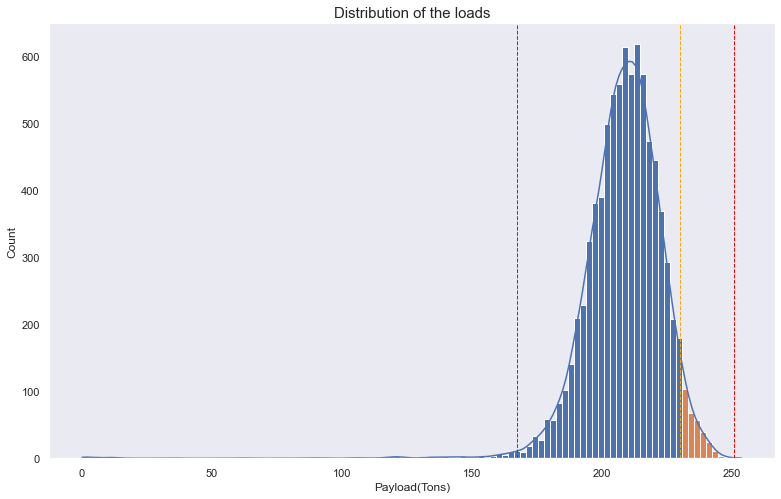

In [54]:
#ploting with seaborn
sns.histplot(df['Payload(Tons)'],kde=True,bins=110, )
_, _, bars = plt.hist(df['Payload(Tons)'], bins = 110)
for bar in bars:
    if bar.get_x() > percent10_load:
        bar.set_facecolor("C1");
        
plt.title('Distribution of the loads', fontdict = {'fontsize' : 15}),
        
# limit between 110% to 120%
plt.axvline(x=max_load, linestyle='--',linewidth=1, color='red')
plt.axvline(x=percent10_load, linestyle='--',linewidth=1, color='orange')
plt.axvline(x=min_load, linestyle='--',linewidth=1, color='green')
plt.show()

## 7. 10/10/20 Rule

Here you can see if you are within the range or not. In this specific situation, the 10/10/20 Rule is being met.

In [55]:
#def function percentage 
def percentage(part, whole):
  percentage = 100 * float(part)/float(whole)
  return str(percentage) + "%"

#Counting total cycles 
total_cycles = df['Payload(Tons)'].between(0, 300) #Range 
total_cycles = np.sum(total_cycles) #Counting the Trues
print('Total Loads:', total_cycles, 'Cycles')

Total Loads: 8398 Cycles


#### Loads in the 90% range of productivity:

In [56]:
good_loads = df['Payload(Tons)'].between(min_load, percent10_load)
good_loads = np.sum(good_loads) #counting the Trues
print('Loads into the range:',good_loads, 'Cycles')
print(percentage(good_loads, total_cycles))

Loads into the range: 7970 Cycles
94.90354846391998%


Here we can see that 94% is met.

#### Loads in the 10% range of the safety limit:

In [57]:
percent_10 = df['Payload(Tons)'].between(percent10_load, max_load)
percent_10 = np.sum(percent_10) #counting the Trues
print('Loads into max limit:',percent_10, 'Cycles')
print(percentage(percent_10, total_cycles))

Loads into max limit: 351 Cycles
4.179566563467493%


Here we can see that 10% is not exceeded.

#### Loads above the maximum safety limit.

In [58]:
no_safety_loads = df['Payload(Tons)'].between(max_load, 300)
no_safety_loads = np.sum(no_safety_loads) #counting the Trues
print('Loads out of limit:', no_safety_loads, 'Cycle')
print(percentage(no_safety_loads, total_cycles))

Loads out of limit: 1 Cycle
0.011907597046915932%


This case is important for safety and this malpractice should be identified.

#### Details of the loads above the maximum safety limit (no safety operation):

In [59]:
df[df['Payload(Tons)'] > max_load]

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day
2022,03/31/2020 00:58:24,23735,SPD00397,253.583,6.317,1.4,1.167,3.283,1.167,7.817,1.4,19.75,2.8,6,9.0,2020,Mar,31


#### Quality of the loads:

Here you can see that there are loads of less than the minimum (167 tons) in certain months. This directly affects equipment production.

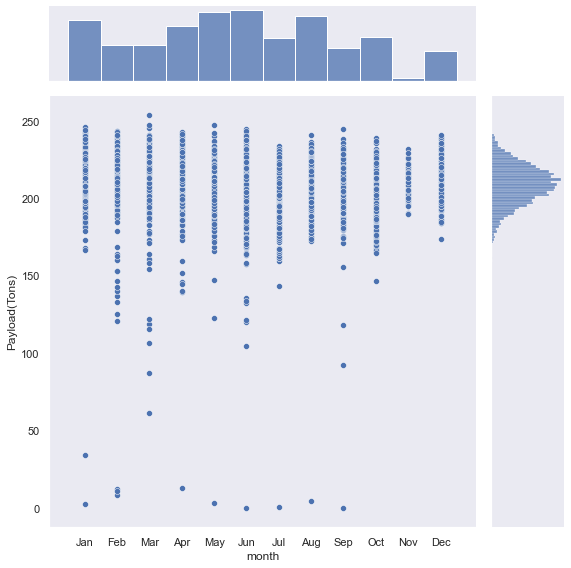

In [60]:
sns.jointplot(x="month", y="Payload(Tons)", data=df, height = 8);

#### Identify where there was greater production:

Here you can see that there are loads of less than the minimum (167 tons) in certain months. This directly affects equipment production.

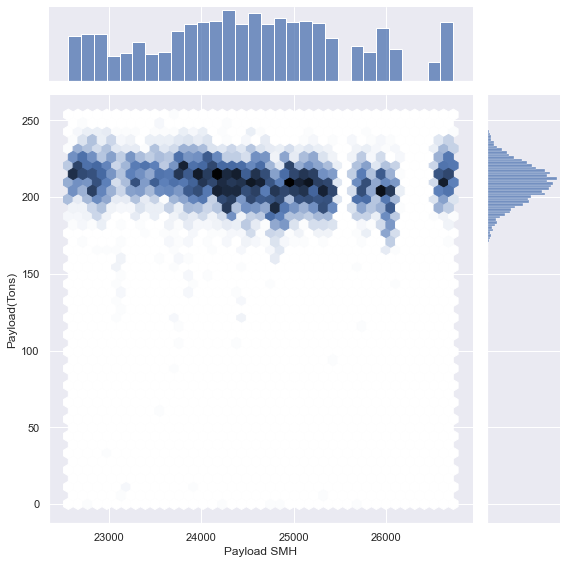

In [61]:
sns.set(style="darkgrid")
sns.jointplot(x="Payload SMH", y="Payload(Tons)", data=df, kind="hex", height = 8);

## 8. Fuel consumption analysis  

Here is the total fuel consumption per month:

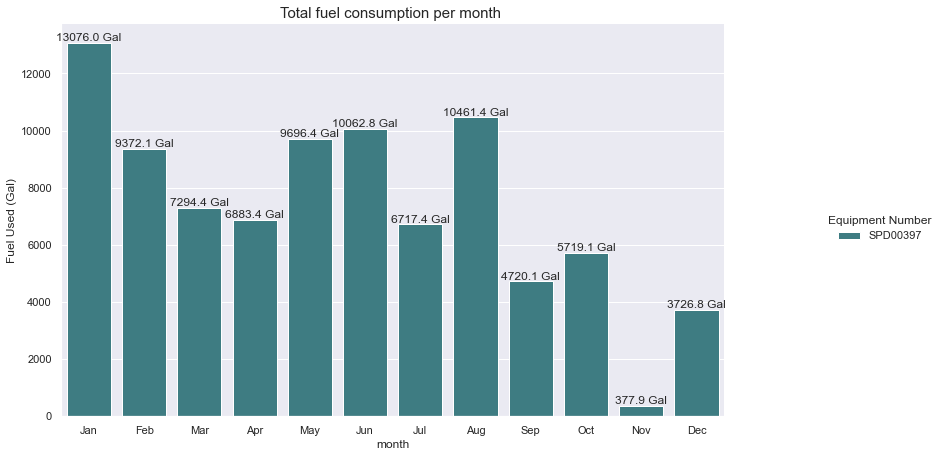

In [62]:
#sns.barplot(x="month", y="Payload(Tons)", data=df, estimator=sum)
g = sns.catplot(x="month", y="Fuel Used (Gal)", data=df, estimator=sum, kind='bar', hue='Equipment Number', legend=True, palette="crest", ci=None)
g.fig.set_size_inches(15, 8)
g.fig.subplots_adjust(top=0.81, right=0.8)

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

#title
plt.title('Total fuel consumption per month ', fontdict = {'fontsize' : 15}),

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height() / 1):.1f} Gal' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

#### Fuel consumption per month (Gallons):

In [63]:
df.groupby(['Equipment Number','month'])["Fuel Used (Gal)"].sum()

Equipment Number  month
SPD00397          Jan      13076.000
                  Feb       9372.125
                  Mar       7294.375
                  Apr       6883.375
                  May       9696.375
                  Jun      10062.750
                  Jul       6717.375
                  Aug      10461.375
                  Sep       4720.125
                  Oct       5719.125
                  Nov        377.875
                  Dec       3726.750
Name: Fuel Used (Gal), dtype: float64

#### Summary of consumption (gallons):
Here are some statistics of the fuel consumption of the Truck.

In [64]:
df.groupby(['Equipment Number','month'])["Fuel Used (Gal)"].describe()

count    mean    std    min     25%     50%     75%  \
Equipment Number month                                                         
SPD00397         Jan     931.0  14.045  6.010  1.625   7.375  17.375  18.750   
                 Feb     556.0  16.856  5.774  3.375  16.750  19.000  20.375   
                 Mar     558.0  13.072  7.143  4.625   7.000   9.188  19.344   
                 Apr     842.0   8.175  3.366  2.875   6.750   7.500   8.250   
                 May    1067.0   9.088  4.434  3.125   7.250   7.875   8.875   
                 Jun    1091.0   9.223  2.933  1.750   8.375   8.750   9.250   
                 Jul     666.0  10.086  2.438  7.625   9.250   9.750  10.500   
                 Aug    1003.0  10.430  3.121  3.500   9.375  10.625  11.375   
                 Sep     505.0   9.347  2.670  2.000   8.000   9.000   9.875   
                 Oct     669.0   8.549  1.478  5.500   7.750   8.375   9.125   
                 Nov      48.0   7.872  1.182  5.875   7.125   7.625   8.406   
                 Dec     462.0   8.067  2.023  3.625   7.250   7.750   8.594   

                           max  
Equipment Number month          
SPD00397         Jan    40.625  
                 Feb    37.750  
                 Mar    54.125  
                 Apr    41.750  
                 May    33.000  
                 Jun    40.875  
                 Jul    62.500  
                 Aug    51.625  
                 Sep    38.375  
                 Oct    21.375  
                 Nov    14.125  
                 Dec    34.125

# 9. Load Factor (%) & Fuel Efficiency (tons/gal)

To get the value of the fuel efficiency of the truck, we need to get gal/hr, hr/year, tons/hr.

In [65]:
#df['operation (hr)'] = df['Cycle Time (hh:mm:ss)'].groupby(df['Payload SMH']).transform('sum') / 60
#cycles per hour
df['Cycles per hour (Cycle/hr)'] = 60 / df['Cycle Time (hh:mm:ss)']
# Fuel consumed per hour 
df['Fuel consumed per hour (Gal/hr)'] = df['Fuel Used (Gal)'].groupby(df['Payload SMH']).transform('sum')
# tons per hour 
df['Tons per hour (Tons/hr)'] = df['Payload(Tons)'].groupby(df['Payload SMH']).transform('sum')
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),...,Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day,Cycles per hour (Cycle/hr),Fuel consumed per hour (Gal/hr),Tons per hour (Tons/hr)
0,01/01/2020 20:53:02,22566,SPD00397,186.329,9.533,2.1,6.450,3.150,1.133,10.833,...,31.100,4.0,5,30.750,2020,Jan,1,1.929,48.750,391.401
1,01/01/2020 21:24:09,22566,SPD00397,205.072,7.350,1.9,1.967,2.517,2.483,11.067,...,25.383,3.7,5,18.000,2020,Jan,1,2.364,48.750,391.401
2,01/01/2020 21:49:32,22567,SPD00397,196.362,6.800,1.9,0.133,3.533,2.600,11.900,...,24.967,3.8,6,17.625,2020,Jan,1,2.403,35.750,406.836
3,01/01/2020 22:14:30,22567,SPD00397,210.474,7.600,1.9,3.767,4.033,0.950,11.400,...,27.750,3.8,7,18.125,2020,Jan,1,2.162,35.750,406.836
4,01/01/2020 22:42:15,22568,SPD00397,208.159,7.050,1.9,1.200,4.383,1.250,11.150,...,25.033,3.8,7,17.750,2020,Jan,1,2.397,52.875,608.710


#### Total operation hours:

In [66]:
total  = df['Cycle Time (hh:mm:ss)'].sum() / 60
df['Total hours per year (hr/year)'] = total
print('Total operation hours', total, 'hrs/year')

Total operation hours 3045.274166666667 hrs/year


#### Averages of consumption per month:

Here is a monthly average of consumption, except 'Total hours per year (hr / year)' which shows the total operational hours in the year.

In [67]:
eficiency = df.groupby(['Equipment Number','month'])['Cycle Time (hh:mm:ss)','Fuel Used (Gal)', 'Fuel consumed per hour (Gal/hr)', 'Cycles per hour (Cycle/hr)','Tons per hour (Tons/hr)', 'Total hours per year (hr/year)'].mean()
eficiency.head(12)

Cycle Time (hh:mm:ss)  Fuel Used (Gal)  \
Equipment Number month                                           
SPD00397         Jan                   25.425           14.045   
                 Feb                   28.292           16.856   
                 Mar                   25.993           13.072   
                 Apr                   20.720            8.175   
                 May                   18.826            9.088   
                 Jun                   19.173            9.223   
                 Jul                   19.414           10.086   
                 Aug                   20.590           10.430   
                 Sep                   23.932            9.347   
                 Oct                   21.300            8.549   
                 Nov                   17.724            7.872   
                 Dec                   20.763            8.067   

                        Fuel consumed per hour (Gal/hr)  \
Equipment Number month                                    
SPD00397         Jan                             32.054   
                 Feb                             34.375   
                 Mar                             28.167   
                 Apr                             24.261   
                 May                             28.464   
                 Jun                             29.275   
                 Jul                             31.541   
                 Aug                             30.203   
                 Sep                             23.400   
                 Oct                             24.199   
                 Nov                             25.794   
                 Dec                             23.265   

                        Cycles per hour (Cycle/hr)  Tons per hour (Tons/hr)  \
Equipment Number month                                                        
SPD00397         Jan                         2.623                  531.314   
                 Feb                         2.343                  464.235   
                 Mar                         2.507                  504.701   
                 Apr                         3.213                  652.811   
                 May                         3.564                  700.181   
                 Jun                         3.442                  677.348   
                 Jul                         3.297                  642.885   
                 Aug                         3.066                  611.514   
                 Sep                         2.640                  526.233   
                 Oct                         2.925                  578.363   
                 Nov                         3.497                  696.876   
                 Dec                         3.023                  631.199   

                        Total hours per year (hr/year)  
Equipment Number month                                  
SPD00397         Jan                          3045.274  
                 Feb                          3045.274  
                 Mar                          3045.274  
                 Apr                          3045.274  
                 May                          3045.274  
                 Jun                          3045.274  
                 Jul                          3045.274  
                 Aug                          3045.274  
                 Sep                          3045.274  
                 Oct                          3045.274  
                 Nov                          3045.274  
                 Dec                          3045.274

#### Load Factor:
With the column 'Fuel consumed per hour (Gal / hr)' we can find out the type of application and load factor of the truck. For example, January had a Medium operation with 30% of Load Factor.

#### Details for this specific model 789:
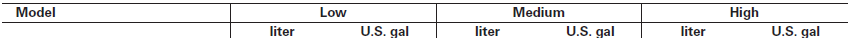



#### Typical Application Description
- Low = Continuous operation at an average gross weight less than recommended. Excellent haul roads. No overloading, low load - factor.

- Medium = Continuous operation at an average gross weight approaching recommended. Minimal overloading, good haul roads, moderate load factor.

- High = Continuous operation at or above maximum recommended gross weight. Overloading, poor haul roads, high load factor.


#### Load Factor Guide
(average engine load factor based on application description for each range)
- Low 20%-30%
- Medium 30%-40%
- High 40%-50%

#### Fuel Eficiency: 

Efficiency is very important when analyzing costs (cost of the ton) and profits in production.


In [68]:
# fuel efficiency = (hrs/year) / (tons/hr * Gal/hr)
ef = eficiency['Tons per hour (Tons/hr)'] * eficiency['Fuel consumed per hour (Gal/hr)']

eficiency['Fuel Eficiency (Tons/Gal)'] = eficiency['Total hours per year (hr/year)'] / ef *100
eficiency.head(12)

Cycle Time (hh:mm:ss)  Fuel Used (Gal)  \
Equipment Number month                                           
SPD00397         Jan                   25.425           14.045   
                 Feb                   28.292           16.856   
                 Mar                   25.993           13.072   
                 Apr                   20.720            8.175   
                 May                   18.826            9.088   
                 Jun                   19.173            9.223   
                 Jul                   19.414           10.086   
                 Aug                   20.590           10.430   
                 Sep                   23.932            9.347   
                 Oct                   21.300            8.549   
                 Nov                   17.724            7.872   
                 Dec                   20.763            8.067   

                        Fuel consumed per hour (Gal/hr)  \
Equipment Number month                                    
SPD00397         Jan                             32.054   
                 Feb                             34.375   
                 Mar                             28.167   
                 Apr                             24.261   
                 May                             28.464   
                 Jun                             29.275   
                 Jul                             31.541   
                 Aug                             30.203   
                 Sep                             23.400   
                 Oct                             24.199   
                 Nov                             25.794   
                 Dec                             23.265   

                        Cycles per hour (Cycle/hr)  Tons per hour (Tons/hr)  \
Equipment Number month                                                        
SPD00397         Jan                         2.623                  531.314   
                 Feb                         2.343                  464.235   
                 Mar                         2.507                  504.701   
                 Apr                         3.213                  652.811   
                 May                         3.564                  700.181   
                 Jun                         3.442                  677.348   
                 Jul                         3.297                  642.885   
                 Aug                         3.066                  611.514   
                 Sep                         2.640                  526.233   
                 Oct                         2.925                  578.363   
                 Nov                         3.497                  696.876   
                 Dec                         3.023                  631.199   

                        Total hours per year (hr/year)  \
Equipment Number month                                   
SPD00397         Jan                          3045.274   
                 Feb                          3045.274   
                 Mar                          3045.274   
                 Apr                          3045.274   
                 May                          3045.274   
                 Jun                          3045.274   
                 Jul                          3045.274   
                 Aug                          3045.274   
                 Sep                          3045.274   
                 Oct                          3045.274   
                 Nov                          3045.274   
                 Dec                          3045.274   

                        Fuel Eficiency (Tons/Gal)  
Equipment Number month                             
SPD00397         Jan                       17.881  
                 Feb                       19.083  
                 Mar                       21.422  
                 Apr                       19.228  
                 May                    

You can check the numbers with this calculator:

source: https://cloud.em.cat.com/fuelcalculator-efficiency?id=a70a48f4-fc2c-47d2-9a92-a2a4c9b7db5b

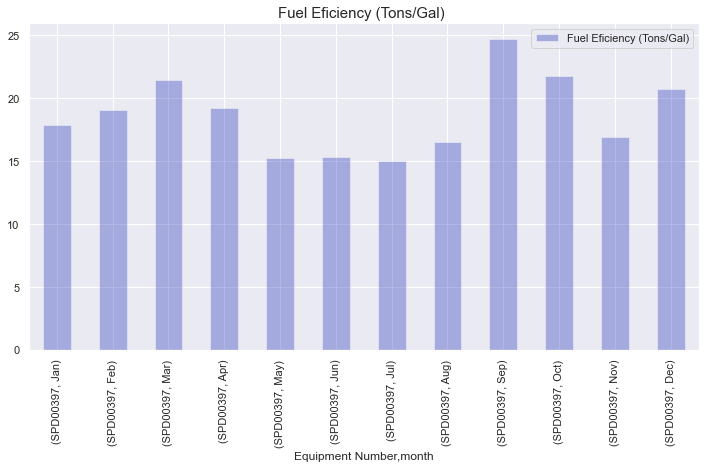

In [69]:
eficiency.plot.bar(y=['Fuel Eficiency (Tons/Gal)'],alpha=0.4, figsize=(12, 6), cmap='coolwarm');
#title
plt.title('Fuel Eficiency (Tons/Gal) ', fontdict = {'fontsize' : 15});

# 10. Operational Effectiveness (Hours)

Here are the total hours per month of the truck's operation:

In [70]:
# data / 60 (minutes) = hrs
efectivity = df.groupby(['Equipment Number','month'])['Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)', 'Cycle Time (hh:mm:ss)'].sum() / 60
efectivity

Travel Empty Time (hh:mm:ss)  \
Equipment Number month                                 
SPD00397         Jan                          87.773   
                 Feb                          58.178   
                 Mar                          57.413   
                 Apr                          62.835   
                 May                          70.468   
                 Jun                          77.714   
                 Jul                          48.720   
                 Aug                          80.846   
                 Sep                          46.701   
                 Oct                          58.502   
                 Nov                           3.881   
                 Dec                          38.409   

                        Stopped Empty Time (hh:mm:ss)  Load Time (hh:mm:ss)  \
Equipment Number month                                                        
SPD00397         Jan                           67.074                63.206   
                 Feb                           43.178                40.557   
                 Mar                           36.807                38.245   
                 Apr                           44.368                55.431   
                 May                           45.106                70.782   
                 Jun                           45.151                65.827   
                 Jul                           29.227                42.965   
                 Aug                           39.500                71.690   
                 Sep                           22.115                34.444   
                 Oct                           25.552                43.300   
                 Nov                            1.063                 2.066   
                 Dec                           18.827                27.499   

                        Stopped Loaded Time (hh:mm:ss)  \
Equipment Number month                                   
SPD00397         Jan                            31.270   
                 Feb                            18.614   
                 Mar                            20.125   
                 Apr                            34.651   
                 May                            40.218   
                 Jun                            47.265   
                 Jul                            17.355   
                 Aug                            22.323   
                 Sep                            16.925   
                 Oct                            15.001   
                 Nov                             0.865   
                 Dec                            13.796   

                        Loaded Travel Time (hh:mm:ss)  Cycle Time (hh:mm:ss)  
Equipment Number month                                                        
SPD00397         Jan                          145.182                394.504  
                 Feb                          101.648                262.175  
                 Mar                           89.143                241.734  
                 Apr                           93.486                290.772  
                 May                          108.223                334.797  
                 Jun                          112.667                348.624  
                 Jul                           77.233                215.501  
                 Aug                          129.836                344.193  
                 Sep                           81.239                201.424  
                 Oct                           95.137                237.491  
                 Nov                            6.304                 14.179  
                 Dec                           61.348                159.879

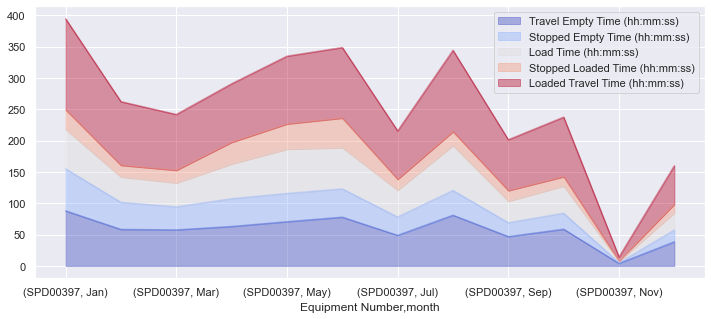

In [71]:
efectivity.plot.area(y=['Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)'],cmap='coolwarm',alpha=0.4, figsize=(12, 5));

# 11. Increased haul & return speed = Increased cycles

A good practice to improve production is to increase the number of cycles.

#### Details and statistics

In [72]:
df.describe()

,Payload SMH,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,day,Cycles per hour (Cycle/hr),Fuel consumed per hour (Gal/hr),Tons per hour (Tons/hr),Total hours per year (hr/year)
count,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.0,8398.000,8398.000,8398.000,8398.000,8.398e+03
mean,24507.770,208.140,4.940,1.004,2.986,3.972,1.989,7.869,1.091,21.757,2.096,5.983,10.492,2020.0,14.701,3.040,28.424,606.023,3.045e+03
std,1068.518,15.762,1.988,0.497,5.651,1.296,3.218,2.912,0.473,8.541,0.855,1.237,4.804,0.0,8.472,0.863,8.513,176.228,4.548e-13
min,22566.000,0.110,0.000,0.000,0.000,0.083,0.667,0.217,0.000,7.517,0.000,1.000,1.625,2020.0,1.000,0.412,5.625,0.221,3.045e+03
25%,23769.250,200.331,3.783,0.700,0.300,3.133,0.983,6.017,0.800,16.717,1.600,5.000,7.625,2020.0,8.000,2.424,22.375,437.156,3.045e+03
50%,24500.000,209.261,4.667,0.900,1.333,3.750,1.150,7.233,1.000,19.867,1.900,6.000,8.875,2020.0,14.000,3.020,27.250,618.523,3.045e+03
75%,25216.000,217.530,5.867,1.200,3.617,4.533,1.717,9.167,1.300,24.750,2.400,7.000,11.000,2020.0,21.000,3.589,34.250,672.326,3.045e+03
max,26722.000,253.583,32.817,6.500,120.000,38.650,120.000,98.900,14.400,145.667,15.400,10.000,62.500,2020.0,31.000,7.982,72.000,1127.673,3.045e+03


#### Production analysis

In [73]:
#### 789D truck
payload  # we defined this previously (ton payload average)
cycle_time = df['Cycle Time (hh:mm:ss)'].mean() #cycle time average
print('Average Cycle Time', cycle_time, 'minutes')
print('Target Payload', payload, 'Tons')

Average Cycle Time 21.757138604429628 minutes
Target Payload 209 Tons


- Counting the cycles:

In [74]:
# 60 minutes / cycle_time
cycles = 60 / cycle_time 
print('Cycles per hour:', cycles , 'cycles/hr')

Cycles per hour: 2.757715575143891 cycles/hr


- Ideal production per hour:

Ideal production includes 4 cycles of 15 minutes per hour/Machine

In [75]:
# 60min / 15 min/cycle = 4 cycles / hr

#4 cycles/hr x 200 tons    =  800 tons/hr
ideal_production = 4 * payload

print('Ideal production:', ideal_production, 'tons/hr')

Ideal production: 836 tons/hr


- Real production per hour:

Actual cycles multiplied by the production target

In [76]:
real_production = cycles * payload 
#3.15 cycles/hr x 210 tons =  661 tons/hr
#125 tons
print('Real production:', real_production, 'tons/hr')

Real production: 576.3625552050732 tons/hr


- Loss production per hour

Ideal production - Real production

In [77]:
total_loss = ideal_production - real_production 
print('loss production per hour:', total_loss , 'tons')

loss production per hour: 259.63744479492675 tons


- Loss Tons per hour 

In [78]:
# 258.56 tons x .75 eff = 193.92 tons
tons_per_month = total_loss * 0.75
print('loss tons per hour:', tons_per_month, 'tons')

loss tons per hour: 194.72808359619506 tons


- Total loss per fleet

Let's assume we have a fleet of 10 trucks:

In [79]:
# 100 tons x 10 trucks = 1000 tons/hr
total_loss_fleet = tons_per_month * 10
print('Total loss per fleet',total_loss_fleet, 'tons/hr')

Total loss per fleet 1947.2808359619507 tons/hr


- Total anual loss per fleet

In [80]:
# 1939.24 tons/hr x 6000 hrs = 11,635,444.05 tons/annual
tons_annual_loss = total_loss_fleet * 6000
print('Total anual loss fleet:',tons_annual_loss, 'tons/annual')

Total anual loss fleet: 11683685.015771704 tons/annual


                                                                                   Ricardo ML 2021 / Mechanical Engineering